# Extra Credit (6 pts) - Hidden Markov Models

## Nisha Dalal nd8288

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import pomegranate as pom
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# single_channel.npy is in the homework/ folder along with this notebook
current_pA = np.load('single_channel.npy')
time_ms = np.arange(len(current_pA)) * 0.2

current_pA.shape

(100000,)

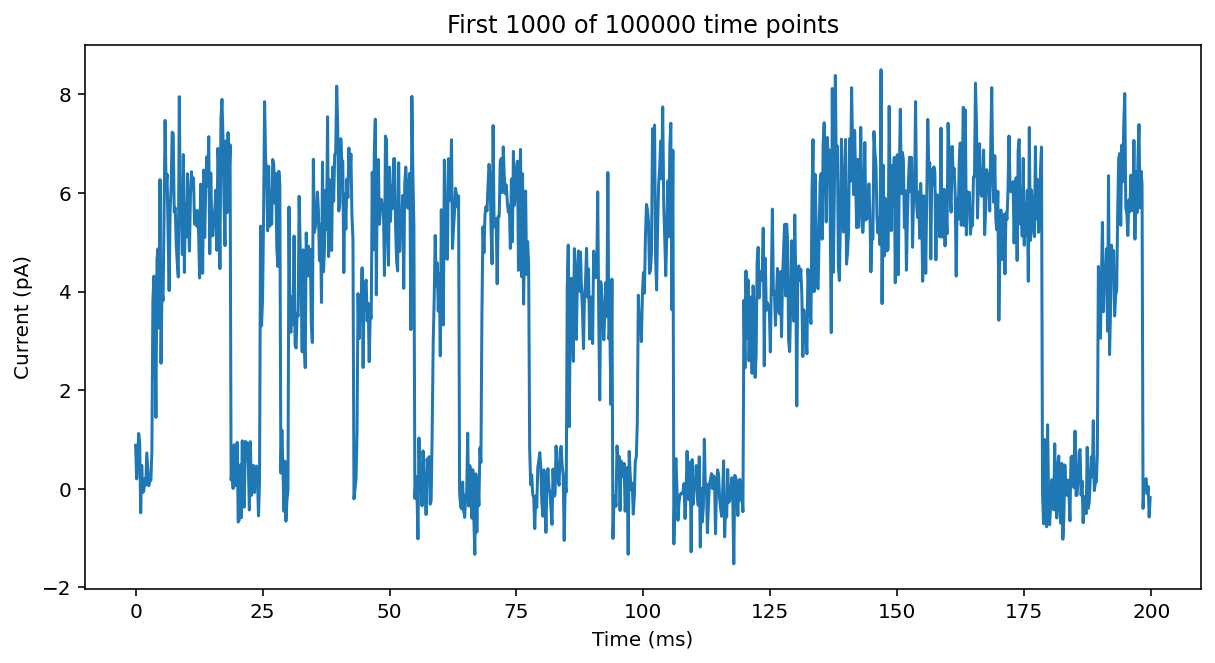

In [3]:
n = 1000
plt.figure(figsize=(10,5))
plt.plot(time_ms[:n], current_pA[:n])
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title(f'First {n} of {len(current_pA)} time points');

1. (2 pts) Postulate an HMM with three states that might explain the `current_pA` data. Build and bake this model using pomegranate. Use normally distributed state emissions.

In [4]:
p0 = np.array([0.5, 0.5])  # P(C), P(O)
trans = np.array([[0.95, 0.05],   # P(C->C), P(C->O)
                  [0.15, 0.85]])  # P(O->C), P(O->O)
emis = [st.norm(0, 1), st.norm(5, 1)]  # closed, open current distributions

In [5]:
def simulateHMM(p0, trans, emis, numSamples, rseed=0):
    numStates = len(p0)
    stateIds = np.arange(numStates)  # 0, 1, ..., numStates-1
    
    # preallocate simulation arrays
    stateSequence = np.zeros(numSamples, dtype=int)
    observationSequence = np.zeros(numSamples)
    
    # reset pseudo random number generator
    np.random.seed(rseed)
    
    # randomly assign starting state
    stateSequence[0] = np.random.choice(stateIds, p=p0)
    
    # randomly assign subsequent states based on the transition probabilities
    for t in range(numSamples-1):
        state = stateSequence[t]
        stateSequence[t+1] = np.random.choice(stateIds, p=trans[state,:])
    
    # randomly draw state observations from emission distributions
    for state in stateIds:
        stateMask = (stateSequence == state)
        observationSequence[stateMask] = emis[state].rvs(stateMask.sum())
    
    return stateSequence, observationSequence

In [6]:
stateSeq, observationSeq = simulateHMM(p0, trans, emis, 1000)

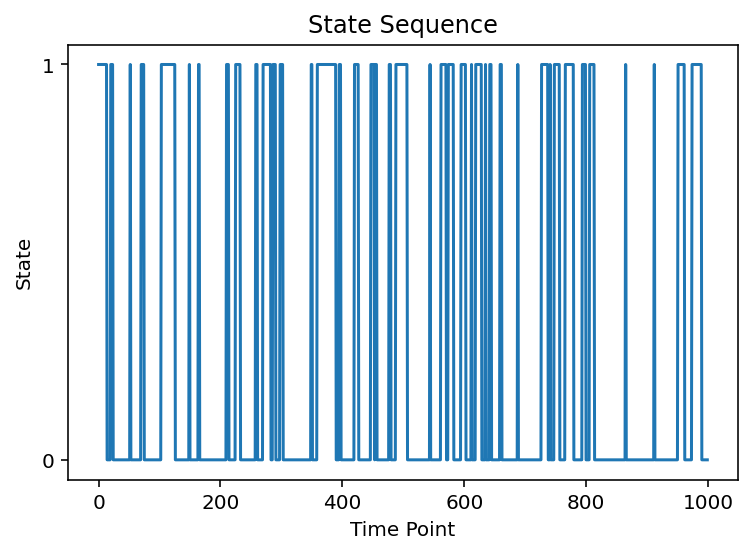

In [7]:
plt.plot(stateSeq)
plt.yticks(np.unique(stateSeq))
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence');

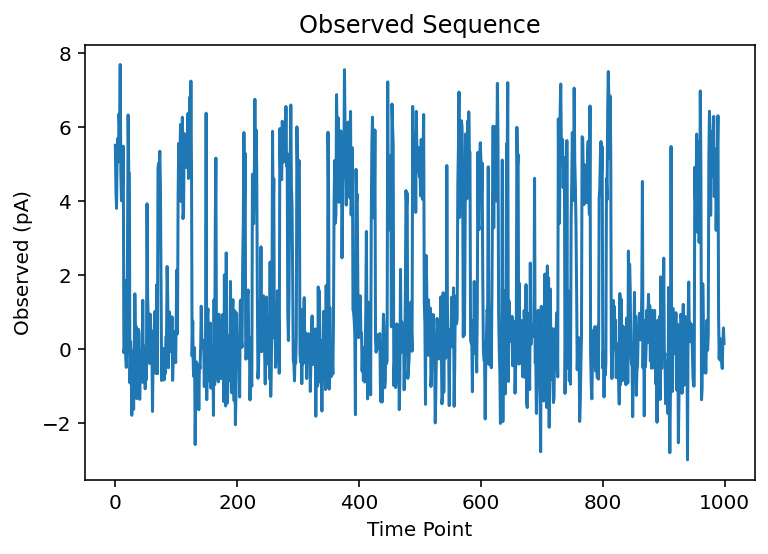

In [8]:
plt.plot(observationSeq)
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Observed Sequence');

2. (2 pts) Train/Optimize your model for the entire current trace using the Baum-Welch algorithm (if this is too much for your computer, use as many points as your machine can reasonably handle). Report the 3x3 matrix of optimized transition probabilities (use a Pandas dataframe so it looks nice, make sure rows and columns are labeled with the correct state names).

In [9]:
hmm = pom.HiddenMarkovModel()

# states
C = pom.State(pom.NormalDistribution(1, 0.8), name='Closed')
O = pom.State(pom.NormalDistribution(7, 1), name='Open')
D = pom.State(pom.NormalDistribution(0, 0.8), name='Desensitized')
hmm.add_states([C, O, D])

# starting probability in each state (MUST add to one)
hmm.add_transition(hmm.start, C, 0.9)
hmm.add_transition(hmm.start, O, 0.1)

# transition probabilites per time step between states
hmm.add_transition(C, C, 0.90)
hmm.add_transition(C, O, 0.10) # sum from C MUST add to one

hmm.add_transition(O, C, 0.05)
hmm.add_transition(O, O, 0.90)
hmm.add_transition(O, D, 0.05) # sum from O MUST add to one

hmm.add_transition(D, O, 0.05)
hmm.add_transition(D, D, 0.95) # sum from D MUST add to one

# we have to bake it before we can use it!
hmm.bake()

In [10]:
hmm.fit([current_pA[:10000]], algorithm='baum-welch');

In [11]:
hmmStateNames = [state.name for state in hmm.states]

states = ["Closed", "Open", "Desensitized"]

# optimized transition probabilities
trans1 = hmm.dense_transition_matrix()
trans1df = pd.DataFrame(trans1, index=hmmStateNames, columns=hmmStateNames)
trans1df.loc[states, states]

,Closed,Open,Desensitized
Closed,0.944037,0.055963,0.000000
Open,0.019019,0.959574,0.021408
Desensitized,0.000000,0.034084,0.965916


3. (2 pts) Plot the first 1000 data points for the current as a semitransparent line and overlay a scatter plot of the same points color-coded by the prediction of the HMM for which state each data point belongs to.

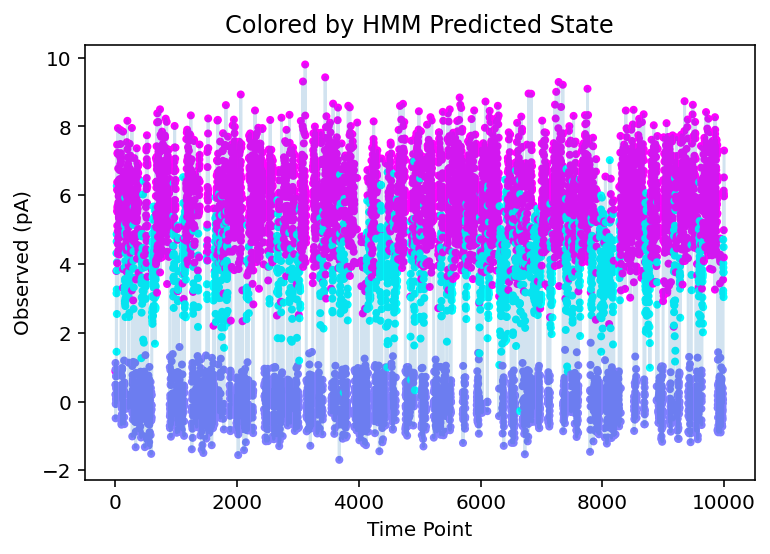

In [12]:
predictedStateSeq = hmm.predict(current_pA)

n = 10000
plt.plot(current_pA[:n], alpha=0.2)
plt.scatter(range(n), current_pA[:n], marker='.', c=predictedStateSeq[:n], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed (pA)')
plt.title('Colored by HMM Predicted State');